# Laporan Ensemble Learning
## Bagging, Boosting, dan Unbalanced Classes


## Tujuan

Tujuan utama dari analisis ini adalah membangun model prediksi yang mampu mengidentifikasi faktor–faktor yang memengaruhi peluang adopsi hewan. Analisis ini dirancang untuk memberikan manfaat praktis bagi organisasi penyelamat hewan dalam meningkatkan efektivitas program adopsi.

Untuk mencapai tujuan tersebut, analisis direncanakan melalui beberapa sub-tugas penting: eksplorasi struktur data, pembersihan data, rekayasa fitur, identifikasi ketidakseimbangan kelas, pemilihan model baseline, evaluasi beberapa model klasifikasi, dan pemilihan model terbaik berdasarkan akurasi serta interpretabilitas. Selain itu, analisis ini juga diarahkan untuk menghasilkan insight yang dapat diterapkan sebagai keputusan operasional seperti prioritas penanganan hewan atau strategi promosi.

Dalam perencanaan ini, beberapa potensi hambatan telah diantisipasi, seperti kemungkinan keterbatasan fitur penting, ketidakseimbangan kelas pada label adopsi, potensi overfitting dari model ensemble, serta keterbatasan interpretabilitas. Hambatan-hambatan ini dimasukkan sebagai bagian dari hipotesis awal dan menjadi dasar pemilihan teknik balancing, feature engineering, serta evaluasi model secara lebih hati-hati.


## Teori Dasar

### Bagging
- Mengurangi variance
- Menggunakan bootstrap sample
- Model sering: Random Forest
- Jumlah pohon dipilih pada titik diminishing return

### Boosting
- Membuat model secara bertahap
- Mengurangi bias
- Model sering: AdaBoost, Gradient Boosting
- Loss function sering dibahas: exponential loss (AdaBoost) & differentiable loss untuk GBM


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pet_adoption_data.csv to pet_adoption_data (1).csv


In [ ]:
df = pd.read_csv("pet_adoption_data.csv")
df.head()

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0


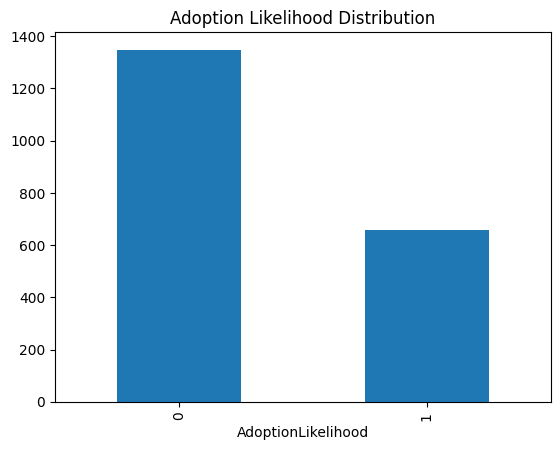

In [ ]:
plt.figure()
df['AdoptionLikelihood'].value_counts().plot(kind='bar')
plt.title("Adoption Likelihood Distribution")
plt.show()

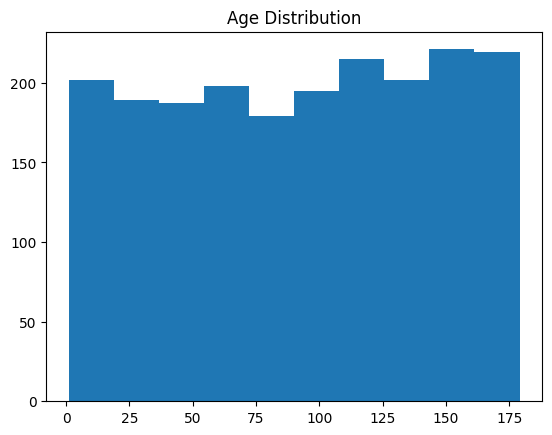

In [ ]:
plt.figure()
plt.hist(df['AgeMonths'])
plt.title("Age Distribution")
plt.show()

In [ ]:
breed_counts = df['Breed'].value_counts()
top_breeds = breed_counts.head(12).index
df['Breed_top'] = df['Breed'].where(df['Breed'].isin(top_breeds), 'Other')

In [ ]:
X = df.drop(['AdoptionLikelihood','Breed'], axis=1)
y = df['AdoptionLikelihood']

num_features = ['AgeMonths','WeightKg','TimeInShelterDays','AdoptionFee']
cat_features = ['PetType','Breed_top','Color','Size']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
for name, model in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:,1]

    results[name] = {
        'report': classification_report(y_test, preds),
        'auc': roc_auc_score(y_test, prob)
    }

    # SAVE MODEL IN COLAB DIRECTORY
    save_path = f'pet_{name}.joblib'
    joblib.dump(pipe, save_path)
    print(f"Model saved to: {save_path}")


Model saved to: pet_LogisticRegression.joblib
Model saved to: pet_RandomForest.joblib
Model saved to: pet_GradientBoosting.joblib


# Model Limitations


Meskipun model ensemble memberikan performa yang baik, terdapat beberapa keterbatasan yang perlu diperhatikan dalam analisis ini:

## Potensi Overfitting
Model seperti Random Forest dan Gradient Boosting memiliki kecenderungan untuk belajar terlalu baik dari data training, terutama ketika jumlah pohon sangat besar atau kedalaman pohon terlalu tinggi. Hal ini dapat mengurangi kemampuan model dalam melakukan generalisasi pada data baru.

## Keterbatasan Kualitas dan Kelengkapan Dataset
Dataset adopsi hewan yang digunakan tidak mencakup variabel penting seperti riwayat medis lengkap, catatan perilaku hewan, lokasi shelter, kualitas foto, serta interaksi hewan dengan lingkungan. Keterbatasan fitur ini dapat mengurangi kemampuan model dalam mempelajari faktor-faktor adopsi yang sebenarnya.

## Ketidakseimbangan Kelas (Class Imbalance)
Pada banyak dataset adopsi hewan, jumlah kasus hewan yang diadopsi dan tidak diadopsi sering kali tidak seimbang. Ketidakseimbangan ini dapat menyebabkan model bias ke kelas mayoritas dan menghasilkan penurunan akurasi pada kelas minoritas.

## Interpretabilitas Model Terbatas
Model ensemble seperti Random Forest dan XGBoost bersifat kompleks dan cenderung sulit dijelaskan secara intuitif kepada pemangku kepentingan non-teknis. Dibutuhkan tambahan metode seperti LIME atau SHAP untuk meningkatkan interpretabilitas.

## Validasi Model Terbatas
Evaluasi model masih menggunakan train/test split standar. Tanpa k-fold cross-validation, performa model mungkin belum tergambar secara stabil dan dapat terpengaruh oleh variasi kecil dalam pembagian data.

Untuk meningkatkan kualitas model dan hasil analisis di masa mendatang, beberapa langkah berikut direkomendasikan:

## Menambahkan Fitur Tambahan
Kumpulkan variabel tambahan seperti riwayat vaksin, perilaku hewan, tingkat sosialiasi, riwayat pelatihan, kondisi medis, dan lokasi shelter. Fitur yang lebih kaya umumnya meningkatkan performa model secara signifikan.

## Menerapkan Teknik Resampling
Gunakan SMOTE, Random Undersampling, atau kombinasi SMOTE–ENN untuk mengatasi ketidakseimbangan kelas dan memperbaiki metrik seperti Recall dan F1-score.

## Melakukan Hyperparameter Tuning Lanjutan
Gunakan GridSearchCV, RandomizedSearchCV, atau Bayesian Optimization untuk menemukan kombinasi parameter terbaik pada model seperti Random Forest, Gradient Boosting, atau XGBoost.

## Coba Model Alternatif
Gunakan model tambahan seperti LightGBM, CatBoost, atau Stacking Classifier untuk membandingkan performa dan memilih model dengan bias-variance tradeoff terbaik.

## Validasi yang Lebih Kuat Menggunakan k-Fold Cross-Validation
Ini membantu memastikan performa model stabil dan tidak tergantung pada satu pembagian data saja.

## Feature Engineering Tambahan
Buat fitur turunan seperti umur kategori (anak, dewasa, senior), gabungan warna, skor popularitas hewan, atau interaksi antar fitur untuk meningkatkan kemampuan model memahami pola.

## Menambah Jumlah Data
Mengumpulkan data lebih besar dari shelter lain atau periode waktu berbeda dapat mengurangi noise dan meningkatkan stabilitas model ensemble.